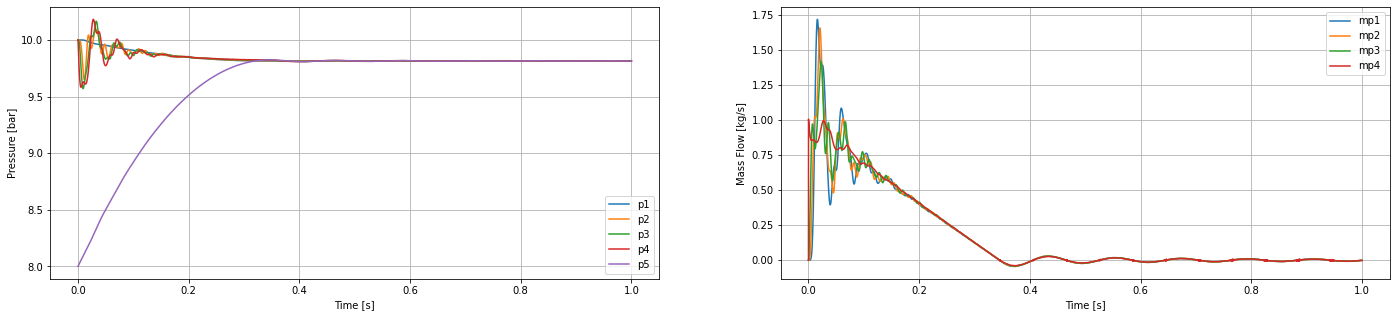

In [5]:
'''
lambda ausrechnen --> wenn dann wegen instabilität impliziter solver notwendig ist, nochmal damit beschäftigen, ansonsten erstmal vsl fertig machen
x ventil
ventil mit dynamik --> evtl weglassen --> wird sonst zu viel; außerdem sollen die selber noch nachdenken
# Y/U=K/(Ts+1)
# y_dot * T + y = K*U
impliziter solver --> gekko (kann dae), pyomo, DAE-scipy
--> DAE system braucht impliziten solver
'''

import numpy as np
import matplotlib.pyplot as plt

#%%% integrators

def forward_euler(f, y, h, t, *args): # euler explicit
    return y + h*f(t, y, *args)

def rk4_e(f, y, h, t, *args): # runge kutta 4th order explicit
    # runge kutte 4th order explicit
    tk_05 = t + 0.5*h
    yk_025 = y + 0.5 * h * f(t, y, *args)
    yk_05 = y + 0.5 * h * f(tk_05, yk_025, *args)
    yk_075 = y + h * f(tk_05, yk_05, *args)
    
    return y + h/6 * (f(t, y, *args) + 2 * f(tk_05, yk_025, *args) + 2 * f(tk_05, yk_05, *args) + f(t+h, yk_075, *args))

#%%% system dynamics

def ode(t, y, *args):
    
    def get_K(p, gamma=1.4):
        return p*gamma
    
    V_1 = args[0]           # m^3
    rho_1 = args[1]         # kg/m^3
    rho_2 = args[2]         # kg/m^3
    rho_3 = args[3]         # kg/m^3
    rho_4 = args[4]         # kg/m^3
    V_5 = args[5]           # m^3
    rho_5 = args[6]         # kg/m^3
    l = args[7]             # m
    A = args[8]             # m^2
    md4 = args[9]           # kg/s

    p1 = y[0]               # Pa
    md1 = y[1]              # kg/s
    p2 = y[2]               # Pa
    md2 = y[3]              # kg/s
    p3 = y[4]               # Pa
    md3 = y[5]              # kg/s
    p4 = y[6]               # Pa
    p5 = y[7]               # Pa
    
    k1 = get_K(p1)
    k2 = get_K(p2)
    k3 = get_K(p3)
    k4 = get_K(p4)
    k5 = get_K(p5)
    
    p1_dot = - k1/rho_1/V_1 * md1
    md1_dot = (p1 - p2 - lam/(2*rho_1*A**2)*md1**2*np.sign(md1))*A/l
    p2_dot = k2/rho_2/(A*l) * (md1 - md2)
    md2_dot = (p2 - p3 - lam/(2*rho_2*A**2)*md2**2*np.sign(md2))*A/l
    p3_dot = k3/rho_3/(A*l) * (md2 - md3)
    md3_dot = (p3 - p4 - lam/(2*rho_3*A**2)*md3**2*np.sign(md3))*A/l
    p4_dot = k4/rho_4/(A*l) * (md3 - md4)
    p5_dot = k5/rho_5/V_5 * md4
    
    return np.array([p1_dot, md1_dot, p2_dot, md2_dot, p3_dot, md3_dot, p4_dot, p5_dot])

def algeb(y_ode_k0, y_ode_k1, y_algeb_k0, A, lam):
    def get_rho(p_k0, p_k1, rho_k0, gamma=1.4):
        return rho_k0*(p_k1/p_k0)**gamma
    
    rho_1 = get_rho(y_ode_k0[0], y_ode_k1[0], y_algeb_k0[0])
    rho_2 = get_rho(y_ode_k0[2], y_ode_k1[2], y_algeb_k0[1])
    rho_3 = get_rho(y_ode_k0[4], y_ode_k1[4], y_algeb_k0[2])
    rho_4 = get_rho(y_ode_k0[6], y_ode_k1[6], y_algeb_k0[3])
    rho_5 = get_rho(y_ode_k0[7], y_ode_k1[7], y_algeb_k0[4])
    
    p4 = y_ode_k1[6]
    p5 = y_ode_k1[7]
    
    md4 = np.sqrt(abs(p4-p5)*2*rho_4*A**2/lam/100)*np.sign(p4-p5) # lam/100 --> friction factor across valve is 100 times bigger than for the pipe
    return np.array([rho_1, rho_2, rho_3, rho_4, rho_5, md4])


#%%% integration parameters & initial conditions

h = 1/10000              # stepsize in seconds
t0 = 0                  # initial time in seconds
tn = 1                  # final time in seconds

time = np.linspace(t0, tn, int((tn-t0)/h)+1)

p1_0 = 10e5             # Pa
md1_0 = 0               # kg/s
p2_0 = p1_0             # Pa
md2_0 = 0               # kg/s
p3_0 = p1_0             # Pa
md3_0 = 0               # kg/s
p4_0 = p1_0             # Pa
p5_0 = 8e5              # Pa

y0_ode = np.array([p1_0, md1_0, p2_0, md2_0, p3_0, md3_0, p4_0, p5_0])#, md1_0, p2_0])#, md2_0, p3_0, p4_0])

#assuming nitrogen at T=273K
rho_1_0 = 1.2336 * p1_0 / 1e5
rho_2_0 = 1.2336 * p2_0 / 1e5
rho_3_0 = 1.2336 * p3_0 / 1e5
rho_4_0 = 1.2336 * p4_0 / 1e5
rho_5_0 = 1.2336 * p5_0 / 1e5
md4_0 = 0

y0_algeb = np.array([rho_1_0, rho_2_0, rho_3_0, rho_4_0, rho_5_0, md4_0])#, md1_0])#, rho_3_0, rho_4_0, md3_0])

states_ode = np.zeros((len(y0_ode), len(time)))
states_algeb = np.zeros((len(y0_algeb), len(time)))

#%%% system & environmental parameters

V_1 = 1                 # m^3
V_5 = 0.1                # m^3
lam = 3                 # dimensionless friction coefficient
A = 0.1**2*np.pi/4       # m^2
l = 1                   # m

#%%% running the integrator

y_ode = y0_ode
y_algeb = y0_algeb

for ii in range(len(time)-1):
        
    states_ode[:, ii] = y_ode
    
    states_algeb[:,ii] = y_algeb
    
    t = time[ii]
    
    args = [V_1, states_algeb[0, ii], states_algeb[1, ii], states_algeb[2, ii], 
            states_algeb[3, ii], V_5, states_algeb[4, ii], l, A, states_algeb[5, ii]]
            
    y_ode = rk4_e(ode, y_ode, h, t, *args)              # runge kutta 4 integrator
    
    y_algeb = algeb(states_ode[:, ii], y_ode, states_algeb[:, ii], A, lam)
    
    print(f'Step {ii+1} of {len(time)-1}'.format(),end="\r",flush=True)
    
#%%% plotting the results

plt.figure(figsize=(24,5))
plt.subplot(121)
plt.plot(time[:-1], states_ode[0, :-1]/1e5, label='p1')
plt.plot(time[:-1], states_ode[2, :-1]/1e5, label='p2')
plt.plot(time[:-1], states_ode[4, :-1]/1e5, label='p3')
plt.plot(time[:-1], states_ode[6, :-1]/1e5, label='p4')
plt.plot(time[:-1], states_ode[7, :-1]/1e5, label='p5')
plt.xlabel('Time [s]')
plt.ylabel('Pressure [bar]')
# plt.ylim(ymin=9.99999, ymax=10.00001)
plt.grid()
plt.legend()

plt.subplot(122)
plt.plot(time[:-1], states_ode[1, :-1], label='mp1')
plt.plot(time[:-1], states_ode[3, :-1], label='mp2')
plt.plot(time[:-1], states_ode[5, :-1], label='mp3')
plt.plot(time[:-1], states_algeb[5, :-1], label='mp4')
plt.xlabel('Time [s]')
plt.ylabel('Mass Flow [kg/s]')
plt.grid()
plt.legend()